# パターン認識

## データの読み込み

### データの読み込み

In [ ]:
from pandas._libs.tslibs.vectorized import normalize_i8_timestamps
import io
import pandas as pd
import csv
import time

start = time.perf_counter()

# リモート
#リアルデータのみ
f2 = ""


# col_names =['DCHit','hitSurfaceArea','momentum','polaCell','azimuth','wireFaceNumber1','z-coordinate','wireCoordinates','driftTime','wireFaceNumber2','z-coordinate','wireCoordinates','driftTime','wireFaceNumber3','z-coordinate','wireCoordinates','driftTime','wireFaceNumber4','z-coordinate','wireCoordinates','driftTime','wireFaceNumber5','z-coordinate','wireCoordinates','driftTime','wireFaceNumber6','z-coordinate','wireCoordinates','driftTime','wireFaceNumber7','z-coordinate','wireCoordinates','driftTime','wireFaceNumber8','z-coordinate','wireCoordinates','driftTime','wireFaceNumber9','z-coordinate','wireCoordinates','driftTime','wireFaceNumber10','z-coordinate','wireCoordinates','driftTime','wireFaceNumber11','z-coordinate','wireCoordinates','driftTime','wireFaceNumber12','z-coordinate','wireCoordinates','driftTime','wireFaceNumber13','z-coordinate','wireCoordinates','driftTime','wireFaceNumber14','z-coordinate','wireCoordinates','driftTime','wireFaceNumber15','z-coordinate','wireCoordinates','driftTime','wireFaceNumber16','z-coordinate','wireCoordinates','driftTime','wireFaceNumber17','z-coordinate','wireCoordinates','driftTime','wireFaceNumber18','z-coordinate','wireCoordinates','driftTime','wireFaceNumber19','z-coordinate','wireCoordinates','driftTime','wireFaceNumber20','z-coordinate','wireCoordinates','driftTime','wireFaceNumber21','z-coordinate','wireCoordinates','driftTime','wireFaceNumber22','z-coordinate','wireCoordinates','driftTime','wireFaceNumber23','z-coordinate','wireCoordinates','driftTime','wireFaceNumber24','z-coordinate','wireCoordinates','driftTime']
col_names = [ 'c{0:02d}'.format(i) for i in range(302) ]


# 結合が必要な場合
# auto1 = pd.read_csv(f1,names=col_names)
# auto2 = pd.read_csv(f2,names=col_names)

# auto = pd.concat([auto1, auto2]) # 結合

auto = pd.read_csv(f2,names=col_names, dtype="float32")

auto3 = pd.read_csv(f3,names=col_names, dtype="float32")
auto4 = pd.read_csv(f4,names=col_names, dtype="float32")

auto2 = pd.concat([auto3, auto4])
auto2['c301'] = 2
print(auto2)
auto = pd.concat([auto, auto2])

del f2,f3,f4, col_names, auto2, auto3, auto4

print(time.perf_counter() - start)

print(auto)

# c301列をc302列にコピー
auto['c302'] = auto['c301'].copy()


# c301列で0以外の値を持つ行をすべて1に変更
auto.loc[auto['c301'] != 0, 'c301'] = 1

print(auto)


             c00     c01         c02       c03          c04         c05  \
0           11.0  1074.0 -227.819458  1.713795  1074.000000 -211.819458   
1           19.0  1074.0 -483.819458  3.617710  1074.000000 -323.819458   
2           27.0  1074.0   28.180544  7.004483  1074.000000  284.180542   
3           53.0  1074.0   60.180546 -0.051305  1074.000000 -227.819458   
4           62.0  1074.0 -595.819458  1.745966  1074.000000  -67.819458   
...          ...     ...         ...       ...          ...         ...   
34021  1499704.0  1074.0 -243.819458  3.349833  1074.000000 -227.819458   
34022  1499722.0  1074.0  -51.819454  6.497899  1074.000000   92.180542   
34023  1499763.0  1074.0  -83.819458  1.022353  1057.812988  -91.853874   
34024  1499811.0  1074.0  -51.819454  6.990298  1074.000000   28.180544   
34025  1499935.0  1074.0 -259.819458  2.683530  1057.812988 -251.853882   

            c06          c07         c08       c09  ...  c292  c293  c294  \
0      7.174957  1074.

### データのクラス割合を調整

In [ ]:
import pandas as pd
from sklearn.utils import resample


print(f"総イベント数{len(auto)}")

# 0と1のデータをそれぞれ抽出
data_0 = auto[auto['c302'] == 0]
data_1 = auto[auto['c302'] == 1]
data_2 = auto[auto['c302'] == 2]

# データ数を取得
count_0 = len(data_0)
count0_1 = len(data_1)
count_2 = len(data_2)

# track有りデータのtrack数1,2の割合を等しくする。
target_count_1_2 = min(50000, min(count0_1, count_2))
sampled0_data_1 = resample(data_1, replace=False, n_samples=80000, random_state=42)
sampled0_data_2 = resample(data_2, replace=False, n_samples=20000, random_state=42)
sampled0_count_1 = len(sampled0_data_1)
sampled0_count_2 = len(sampled0_data_2)
# 新しいデータフレームに結合
data_1 = pd.concat([sampled0_data_1, sampled0_data_2])

print(f'Sampled 1s: {sampled0_count_1}, Sampled 2s: {sampled0_count_2}')

del sampled0_data_1, sampled0_data_2,sampled0_count_1,sampled0_count_2,data_2,target_count_1_2

count_1 = len(data_1)

# サンプリング後の目標データ数を設定
target_count_0_1 = min(100000, min(count_0, count_1))  # 最大200,000になるように調整

# resample関数を使ってサンプリング
sampled_data_0 = resample(data_0, replace=False, n_samples=target_count_0_1, random_state=42)
sampled_data_1 = resample(data_1, replace=False, n_samples=target_count_0_1, random_state=42)
sampled_count_0 = len(sampled_data_0)
sampled_count_1 = len(sampled_data_1)

# 新しいデータフレームに結合
auto = pd.concat([sampled_data_0, sampled_data_1])

del data_0, data_1, sampled_data_0, sampled_data_1

# 割合を表示
print(f'Original class 0: {count_0}, Original class 1: {count0_1}, Original class 2: {count_2}')
print(f'Sampled 0s: {sampled_count_0}, Sampled 1s: {sampled_count_1}')

del sampled_count_0, sampled_count_1,count_0,count0_1,count_2,target_count_0_1



総イベント数569294
Sampled 1s: 90000, Sampled 2s: 10000
Original class 0: 410248, Original class 1: 103451, Original class 2: 55595
Sampled 0s: 100000, Sampled 1s: 100000


### 入力層に取り込む列のラベルのリストを作成

In [ ]:
col_names = [col for col in auto.columns if 'c' in col]
col_names.remove('c00')
col_names.remove('c301')
col_names.remove('c302')
print(col_names)

['c01', 'c02', 'c03', 'c04', 'c05', 'c06', 'c07', 'c08', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c28', 'c29', 'c30', 'c31', 'c32', 'c33', 'c34', 'c35', 'c36', 'c37', 'c38', 'c39', 'c40', 'c41', 'c42', 'c43', 'c44', 'c45', 'c46', 'c47', 'c48', 'c49', 'c50', 'c51', 'c52', 'c53', 'c54', 'c55', 'c56', 'c57', 'c58', 'c59', 'c60', 'c61', 'c62', 'c63', 'c64', 'c65', 'c66', 'c67', 'c68', 'c69', 'c70', 'c71', 'c72', 'c73', 'c74', 'c75', 'c76', 'c77', 'c78', 'c79', 'c80', 'c81', 'c82', 'c83', 'c84', 'c85', 'c86', 'c87', 'c88', 'c89', 'c90', 'c91', 'c92', 'c93', 'c94', 'c95', 'c96', 'c97', 'c98', 'c99', 'c100', 'c101', 'c102', 'c103', 'c104', 'c105', 'c106', 'c107', 'c108', 'c109', 'c110', 'c111', 'c112', 'c113', 'c114', 'c115', 'c116', 'c117', 'c118', 'c119', 'c120', 'c121', 'c122', 'c123', 'c124', 'c125', 'c126', 'c127', 'c128', 'c129', 'c130', 'c131', 'c132', 'c133', 'c134', 'c135', 'c136', 'c137', 'c

## データの整理・分析

In [ ]:
# データ加工・処理・分析ライブラリ
import numpy as np
import numpy.random as random
import scipy as sp
from pandas import Series, DataFrame
import pandas as pd

# 可視化ライブラリ
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

# 機械学習ライブラリ
import sklearn

# 小数第3位まで表示
# %precision 3

In [ ]:
# データの形式と欠損数を出力
print('データの形式:{}'.format(auto.shape))
print('欠損の数:{}'.format(auto.isnull().sum().sum()))

# 目的変数のクラス割合を出力
total_rows = len(auto)
count_0 = auto['c401'].value_counts()[0]
count_1 = auto['c401'].value_counts()[1]

ratio_0 = count_0 / total_rows
ratio_1 = count_1 / total_rows

print(f'class 0: {ratio_0:.2f}')
print(f'class 1: {ratio_1:.2f}')

# データの先頭5行を出力
auto.head(100)

データの形式:(200000, 203)
欠損の数:0
class 0: 0.50
class 1: 0.50


,c00,c02,c03,c06,c07,c10,c11,c14,c15,c18,...,c386,c387,c390,c391,c394,c395,c398,c399,c400,c401
747164,487419,434.2,388,434.2,404,434.2,420,434.2,436,418.2,...,0.0,0,0.0,0,0,0,0,0,0,0
484713,1354164,498.2,4,482.2,12,450.2,-4,418.2,-4,671.8,...,0.0,0,0.0,0,0,0,0,0,0,0
710760,1312456,498.2,-12,482.2,-20,482.2,-4,466.2,-28,450.2,...,0.0,0,0.0,0,0,0,0,0,0,0
174866,1520092,703.8,-604,703.8,-588,687.8,-596,687.8,-580,671.8,...,0.0,0,0.0,0,0,0,0,0,0,0
853188,988827,498.2,-252,498.2,-236,498.2,36,482.2,-244,482.2,...,0.0,0,0.0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
487672,425461,498.2,452,498.2,468,482.2,444,482.2,460,466.2,...,0.0,0,0.0,0,0,0,0,0,0,0
340683,1243893,671.8,4,1026.0,-12,1042.0,-4,1074.0,-4,0.0,...,0.0,0,0.0,0,0,0,0,0,0,0
78599,290596,498.2,-220,498.2,-12,498.2,36,498.2,52,482.2,...,0.0,0,0.0,0,0,0,0,0,0,0
454797,224709,498.2,-636,498.2,-620,498.2,212,482.2,-628,482.2,...,0.0,0,0.0,0,0,0,0,0,0,0


## tensowflowで行う機械学習

### パッケージ

In [ ]:

import sys
sys.setrecursionlimit(2000)
import numpy as np

from __future__ import print_function

from matplotlib import pyplot as plt
import tensorflow as tf
print(tf.__version__)
from tensorflow.python.client import device_lib

# At KEK
import tensorflow.keras as kera
#
from tensorflow.keras import backend
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from keras.optimizers import SGD

from sklearn.model_selection import train_test_split
from hyperopt import Trials
import hyperopt
from hyperopt import fmin, tpe, hp
from sklearn.metrics import f1_score, recall_score, precision_score
from keras.callbacks import LearningRateScheduler
from datetime import datetime

2.15.0


### event番号ありのデータの学習

#### 学習と評価

In [ ]:

epochs = 20

X = auto[col_names] # すべての列を扱う
y = auto['c301']


c00_info = auto['c00'] # 列"c00"（イベント番号）を別の変数に保存
c302_info = auto['c302'] #  列"c302"（トラック数）を別の変数に保存

# 訓練データとテストデータに分ける
x_train, x_test, y_train, y_test, c00_train, c00_test, c302_train, c302_test = train_test_split(X, y, c00_info, c302_info, test_size=0.3, random_state=0)

del auto,X,y,c00_info

#### ハイパーパラメータ探索

1875/1875 [==============================] - 5s 3ms/step

Current parameters: {'batch_size': 512, 'epochs': 19, 'layers': 15, 'learning_rate': 0.02579691909077725, 'neurons': 1024}
Current F1 score: 0.0
1875/1875 [==============================] - 7s 4ms/step

Current parameters: {'batch_size': 128, 'epochs': 7, 'layers': 20, 'learning_rate': 0.06776001975818964, 'neurons': 1024}
Current F1 score: 0.0
1875/1875 [==============================] - 5s 2ms/step

Current parameters: {'batch_size': 256, 'epochs': 15, 'layers': 12, 'learning_rate': 0.04151601288196428, 'neurons': 128}
Current F1 score: 0.0
1875/1875 [==============================] - 6s 3ms/step

Current parameters: {'batch_size': 128, 'epochs': 11, 'layers': 19, 'learning_rate': 0.09967313636110714, 'neurons': 512}
Current F1 score: 0.0
1875/1875 [==============================] - 6s 3ms/step

Current parameters: {'batch_size': 256, 'epochs': 7, 'layers': 8, 'learning_rate': 0.042710083597206724, 'neurons': 128}
Current F1 s

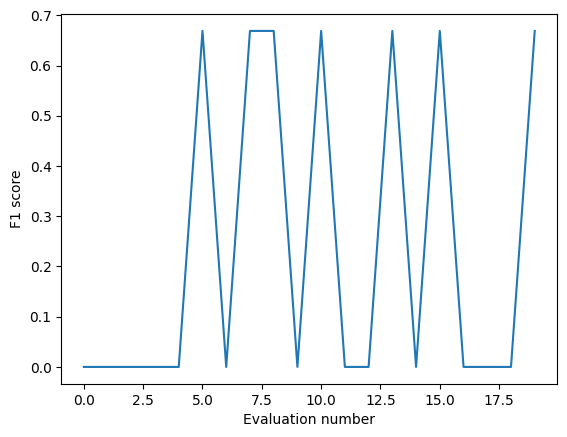

2421.815243907


In [ ]:
start = time.perf_counter()

input_size = 300
output_size = 1
threshold = 0.5

# F1スコアを保存するためのリストを作成
f1_scores = []

# Step 1: ハイパーパラメータ探索範囲を定義
space = {
    'batch_size': hp.choice('batch_size', [64, 128, 256, 512]), #バッチサイズ
    'layers': hp.randint('layers', 20) + 5,  # 中間層
    'neurons': hp.choice('neurons', [64, 128, 256, 512,1024]), #ニューロン数
    'learning_rate': hp.loguniform('learning_rate', -4, -2),
    # 'threshold': hp.uniform('threshold', 0.5, 0.9)
}

# Step 2: 目的関数を定義
def objective(params):
    batch_size = params['batch_size']
    layers = params['layers']
    neurons = params['neurons']
    learning_rate = params['learning_rate']

    # class_weights = {0: 1.0, 1: 2.0}  # 重みを調整

    # モデルの構築と訓練
    model = Sequential()
    model.add(Dense(input_size, activation='relu', input_shape=(input_size,)))
    model.add(Dropout(0.2))
    for i in range(1, layers-1):
        model.add(Dense(neurons, activation='relu'))
        model.add(Dropout(0.2))
    model.add(Dense(output_size, activation='sigmoid'))

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                  optimizer=kera.optimizers.Adam(learning_rate),
                  metrics=['accuracy'])




    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=0,
                        validation_data=(x_test, y_test),
                        # class_weight=class_weights #重みづけ
    )

    # F1スコアを評価指標
    y_pred = model.predict(x_test)
    # 予測されたクラスを取得（確率が0.5以上の場合は1、それ以外の場合は0としています）
    y_pred_classes = np.where(y_pred >= threshold, 1, 0)

    # 指標の計算
    f1 = f1_score(y_test, y_pred_classes) # F1スコアを計算

    f1_scores.append(f1)
    print(f"Current parameters: {params}")
    print(f"Current F1 score: {f1}")
    if f1 < 0.7:
      f1=0.0

    return -f1  # 目的関数は最大化する必要があるため、負のF1スコアを返す



    # 全体の正答率を評価指標
    # val_accuracy = history.history['val_accuracy'][-1]  # 最終エポックの検証正答率を評価指標とする

    # return -val_accuracy  # 目的関数は最大化する必要があるため、負の正答率を返す


# Step 3: hyperoptを使用して最適なハイパーパラメータを探索
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=30)  # 30回評価
print("Best Hyperparameters:", best)

# F1スコアを図にする
plt.plot(f1_scores)
plt.xlabel('Evaluation number')
plt.ylabel('F1 score')
plt.show()

print(time.perf_counter() - start)

#### 学習

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 300)               90300     
                                                                 
 dropout_6 (Dropout)         (None, 300)               0         
                                                                 
 dense_8 (Dense)             (None, 64)                19264     
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 64)               

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


274/274 [==============================] - 33s 122ms/step - loss: 0.6924 - accuracy: 0.5018 - val_loss: 0.6929 - val_accuracy: 0.4974 - test_f1: 0.0000e+00 - train_f1: 0.0000e+00 - test_recall: 0.0000e+00 - train_recall: 0.0000e+00 - test_precision: 0.0000e+00 - train_precision: 0.0000e+00
Epoch 3/15
 23/274 [=>............................] - ETA: 1s - loss: 0.6925 - accuracy: 0.5064

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


274/274 [==============================] - 28s 101ms/step - loss: 0.6922 - accuracy: 0.5041 - val_loss: 0.6900 - val_accuracy: 0.5077 - test_f1: 0.6712 - train_f1: 0.6679 - test_recall: 0.9999 - train_recall: 0.9998 - test_precision: 0.5052 - train_precision: 0.5014
Epoch 4/15
274/274 [==============================] - 19s 71ms/step - loss: 0.6935 - accuracy: 0.5039 - val_loss: 0.6859 - val_accuracy: 0.5188 - test_f1: 0.6756 - train_f1: 0.6729 - test_recall: 0.9973 - train_recall: 0.9973 - test_precision: 0.5109 - train_precision: 0.5078
Epoch 5/15
274/274 [==============================] - 17s 63ms/step - loss: 0.6732 - accuracy: 0.5627 - val_loss: 0.6357 - val_accuracy: 0.6628 - test_f1: 0.7119 - train_f1: 0.7114 - test_recall: 0.8291 - train_recall: 0.8315 - test_precision: 0.6238 - train_precision: 0.6216
Epoch 6/15
274/274 [==============================] - 17s 62ms/step - loss: 0.6364 - accuracy: 0.6445 - val_loss: 0.6236 - val_accuracy: 0.6807 - test_f1: 0.7343 - train_f1: 0.734

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20240602091416allDataNoiseReduction.h5
Test loss: 0.5524584054946899
Test accuracy: 0.7373166680335999
1875/1875 [==============================] - 3s 2ms/step
f1_score 0.7414491707541135


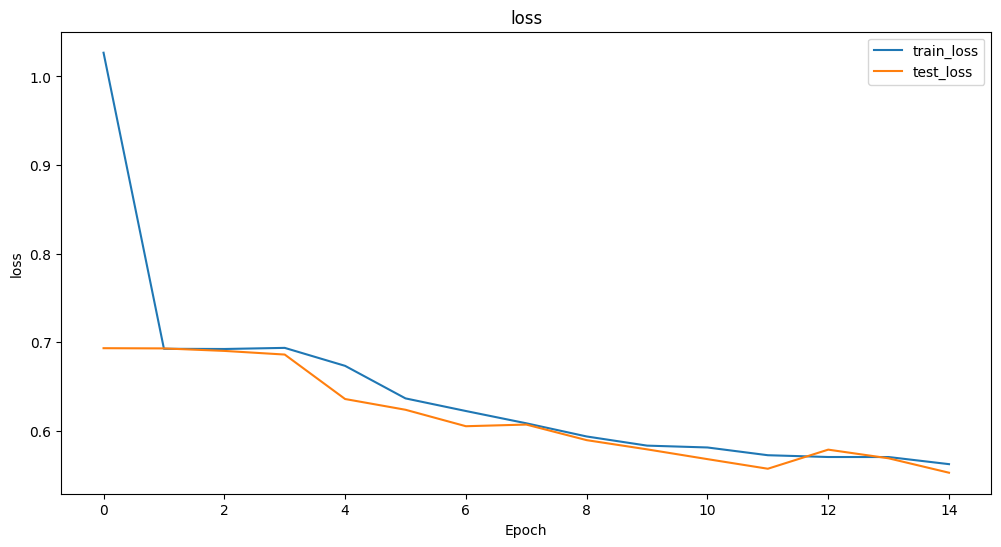

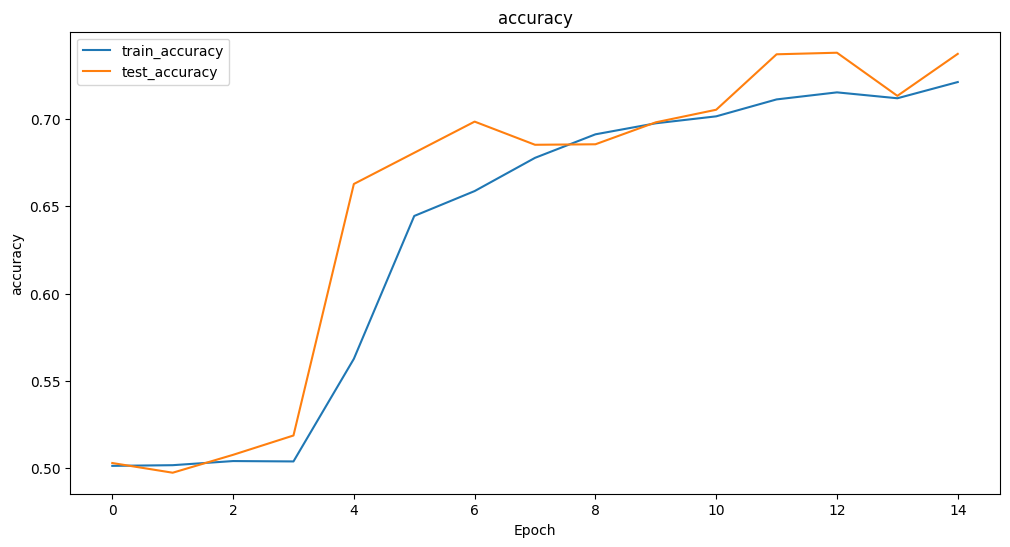

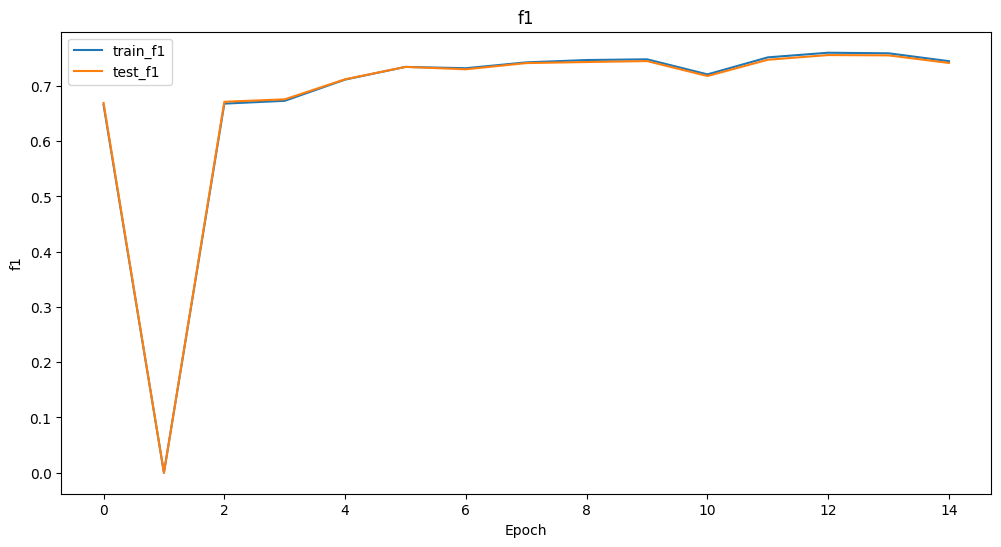

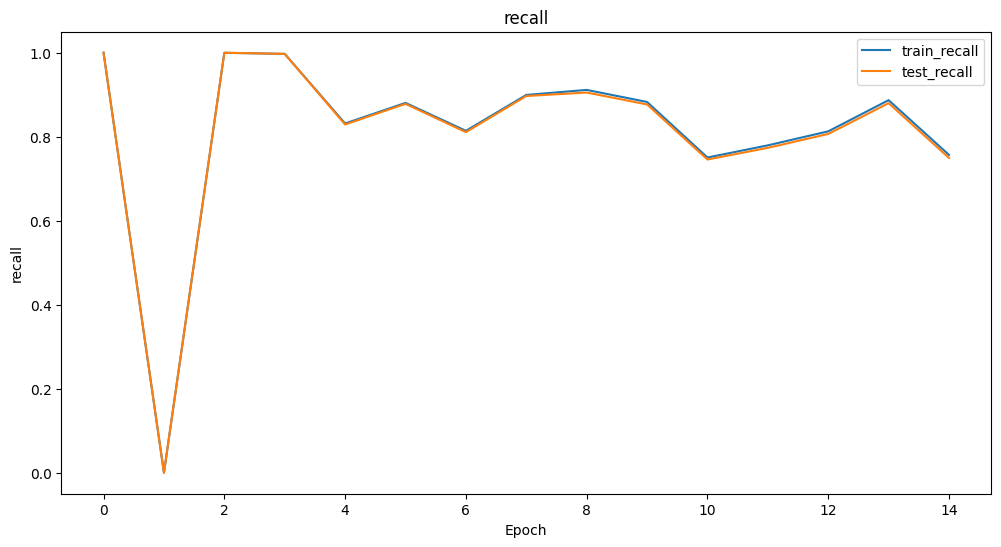

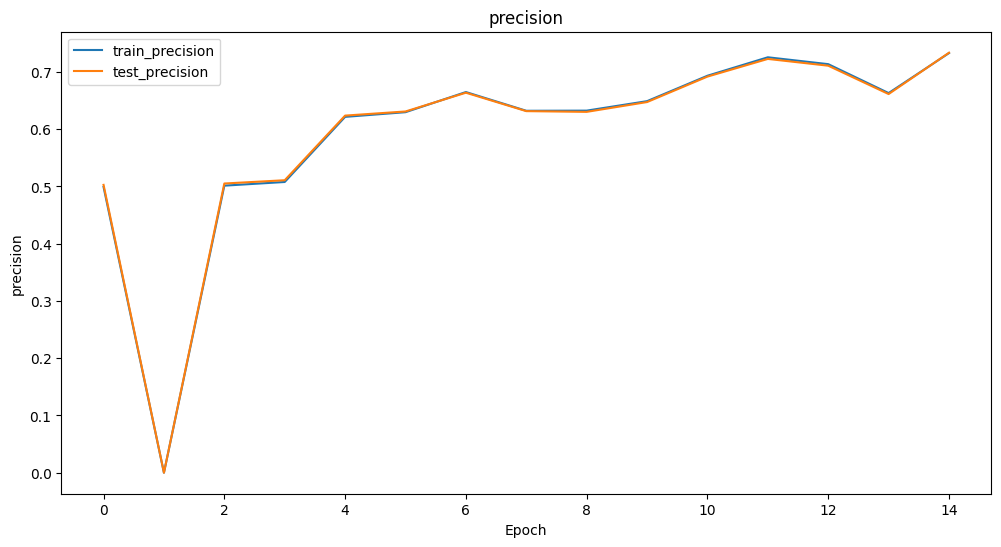

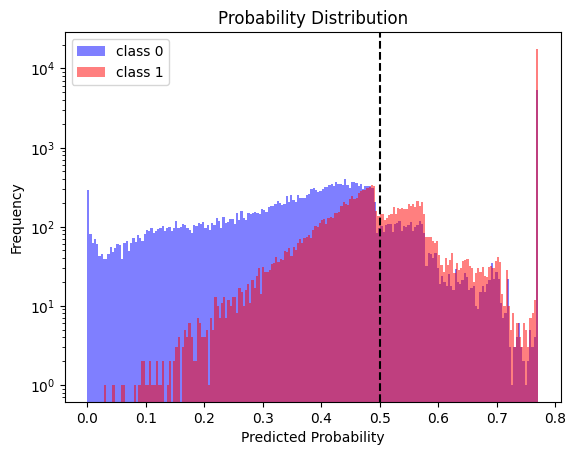

y_pred_0 の要素数: 29847
y_pred_1 の要素数: 30153
y_pred_0 > threshold の要素数: 8207
y_pred_1 > threshold の要素数: 22599
397.500978605


In [ ]:
start = time.perf_counter()

tf.keras.utils.set_random_seed(1)
tf.config.experimental.enable_op_determinism()

input_size = 300
output_size = 1


batch_size = 512
epochs = 15
layers = 7
neurons = 64
learning_rate = 0.007845788392533845
threshold = 0.5

# class_weights = {0: 1.0, 1: 2.0}  # class1の重みを調整

# # tf.keras.layers.Normalization レイヤーを追加
# normalization_layer = tf.keras.layers.Normalization(axis=-1)
# normalization_layer.adapt(x_train)
# x_train = normalization_layer(x_train)
# print(x_train)

model = Sequential()

# model.add(InputLayer(input_shape=(200,)))
model.add(Dense(input_size, activation='relu', input_shape=(input_size,)))
model.add(Dropout(0.2))

# middle layer 2 to layer 500
for i in range(1, layers-1, 1):
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(0.2))

model.add(Dense(output_size, activation='sigmoid'))

model.summary()



def track_acc(self, x, y_true, logs):
    # テストデータに対する予測を取得
    y_pred = self.model.predict(x)
    # 予測されたクラスを取得（確率が0.5以上の場合は1、それ以外の場合は0としています）
    y_pred_classes = np.where(y_pred >= threshold, 1, 0)

    # 指標の計算
    f1 = f1_score(y_true, y_pred_classes)
    recall = recall_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes)

    del y_pred, y_pred_classes


    return {'f1': f1, 'recall': recall, 'precision': precision}

class ElementwiseAccuracy(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test_acc = track_acc(self, x_test, y_test, logs)
        train_acc = track_acc(self, x_train, y_train, logs)
        logs['test_f1'] = test_acc['f1']
        logs['train_f1'] = train_acc['f1']
        logs['test_recall'] = test_acc['recall']
        logs['train_recall'] = train_acc['recall']
        logs['test_precision'] = test_acc['precision']
        logs['train_precision'] = train_acc['precision']

# カスタムコールバックを定義
accuracy_callback = ElementwiseAccuracy()



# モデルのコンパイル時にコールバックを指定
# model.compile(loss='categorical_crossentropy',
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=kera.optimizers.Adam(learning_rate),
              metrics=['accuracy'])

# モデルの訓練時にコールバックを指定
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[accuracy_callback],
                    # class_weight=class_weights,
)

# モデルの保存
# 現在の日時を取得
now = datetime.now()
# 日時を文字列に変換（例: '2024-05-29_14-12-02'）
timestamp_str = now.strftime("%Y%m%d%H%M%S")
# ファイル名を作成（例: 'my_model_2024-05-29_14-12-02.h5'）
filename = timestamp_str + 'allDataNoiseReduction.h5'
# モデルの保存
model.save("" + filename)
print(filename)

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# 出力の確率分布の表示のための整形
y_pred_array = np.array(model.predict(x_test))
y_test_array = np.array(y_test)
c302_test_array = np.array(c302_test)

y_pred_0 = y_pred_array[y_test_array == 0]
y_pred_1 = y_pred_array[y_test_array == 1]

# トラック数ごとで正答率を確認するため
y_pred_track = [y_pred_array[c302_test_array == i] for i in range(6)]

# F1スコアを計算
y_pred_classes = np.where(y_pred_array >= threshold, 1, 0)
f1 = f1_score(y_test, y_pred_classes)
print("f1_score",f1)


def plot_history(train_history, test_history, title, train_label, test_label):
  plt.figure(figsize=(12, 6))
  plt.plot(train_history, label=train_label)
  plt.plot(test_history, label=test_label)
  plt.title(title)
  plt.ylabel(title)
  plt.xlabel('Epoch')
  plt.legend()
  plt.show()

# Plot loss
plot_history(history.history['loss'], history.history['val_loss'], 'loss', 'train_loss', 'test_loss')

# Plot accuracy
plot_history(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 'train_accuracy', 'test_accuracy')

# Plot f1
plot_history(history.history['train_f1'], history.history['test_f1'], 'f1', 'train_f1', 'test_f1')

# Plot recall
plot_history(history.history['train_recall'], history.history['test_recall'], 'recall', 'train_recall', 'test_recall')

# Plot precision
plot_history(history.history['train_precision'], history.history['test_precision'], 'precision', 'train_precision', 'test_precision')

#出力の確率分布を表示
plt.hist(y_pred_0, bins=200, alpha=0.5, color='blue', label='class 0')
plt.hist(y_pred_1, bins=200, alpha=0.5, color='red', label='class 1')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution')
plt.axvline(x=threshold, color='black', linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()

print("y_pred_0 の要素数:", len(y_pred_0))
print("y_pred_1 の要素数:", len(y_pred_1))
print("y_pred_0 > threshold の要素数:", len(y_pred_0[y_pred_0 > threshold] == "true"))
print("y_pred_1 > threshold の要素数:", len(y_pred_1[y_pred_1 > threshold] == "true"))



print(time.perf_counter() - start)

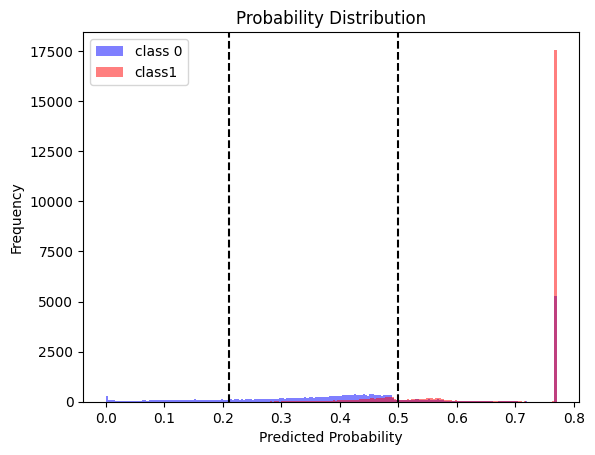

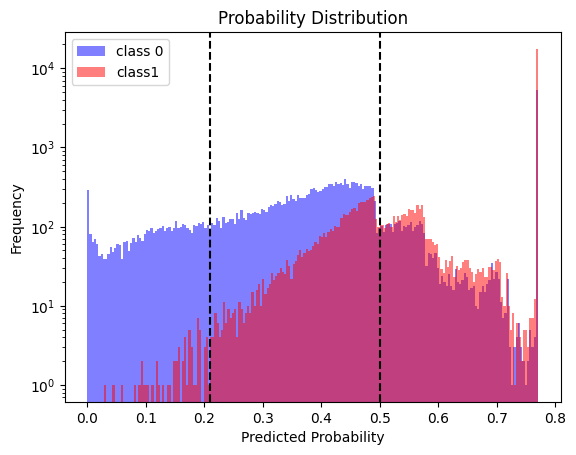

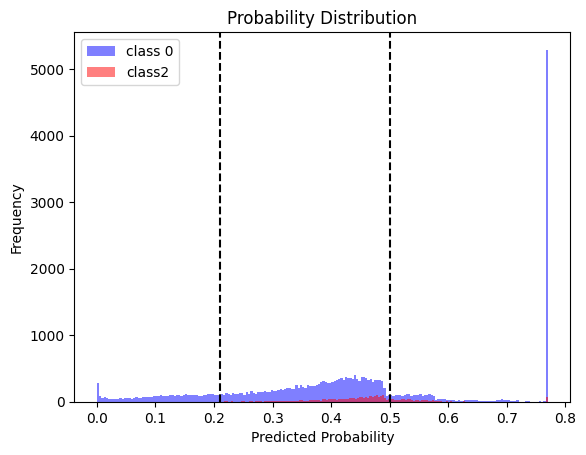

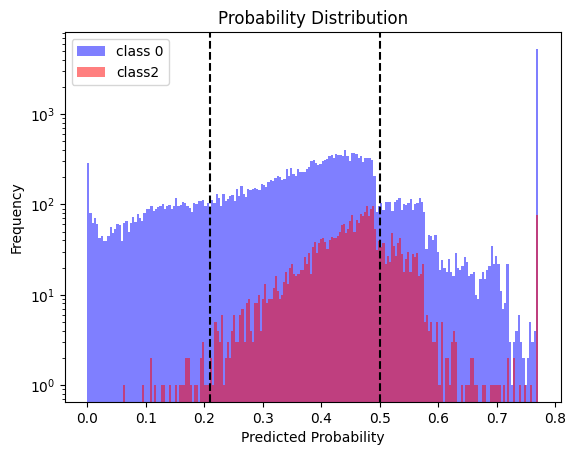

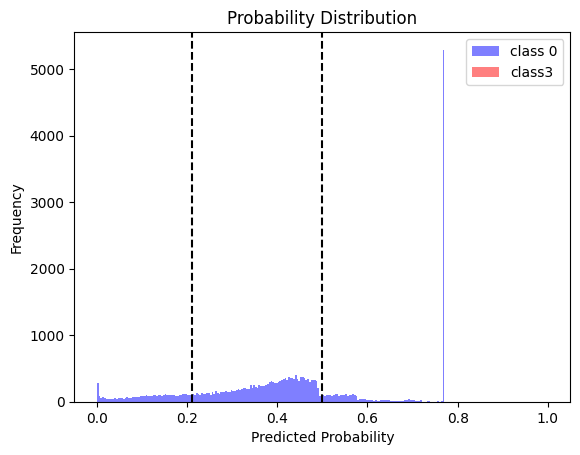

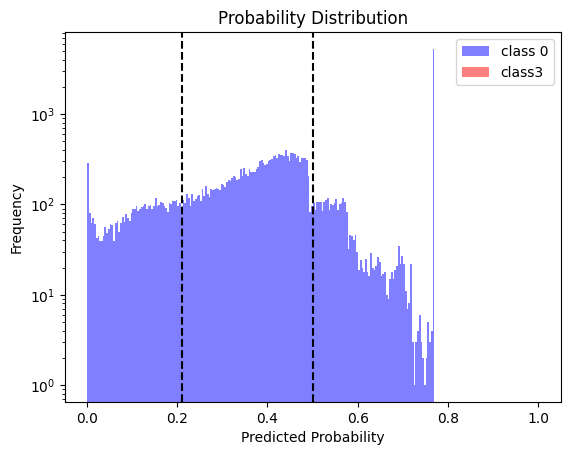

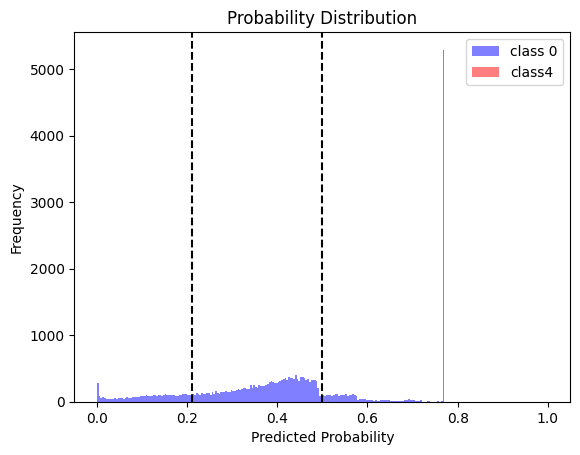

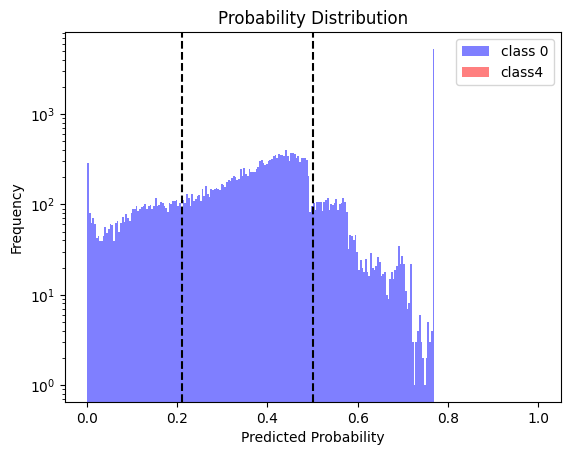

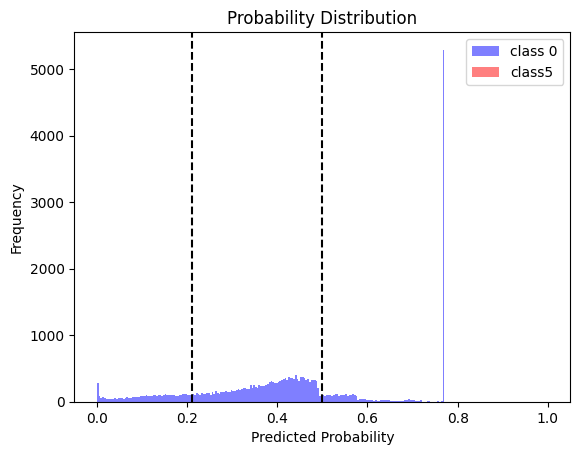

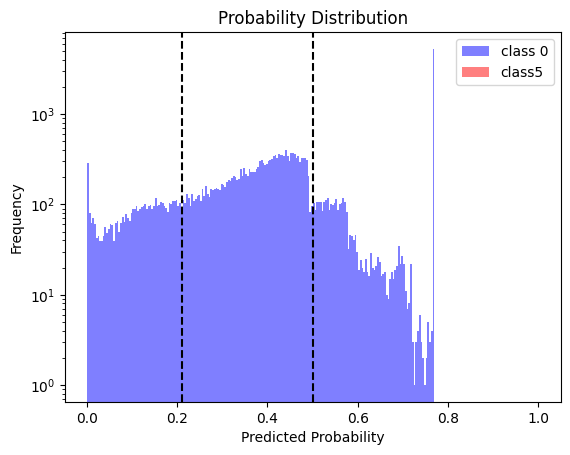

y_pred_0 の要素数: 29847
y_pred_1 の要素数: 30153
y_pred_0> 0.21 の割合: 0.8478574061044661
y_pred_1> 0.21 の割合: 0.9971147149537359
y_pred_0> 0.5 の割合: 0.2749690086105806
y_pred_1> 0.5 の割合: 0.7494776639140384
y_pred_track[0] の要素数: 29847
y_pred_track[0]> 0.21 の割合: 0.8478574061044661
y_pred_track[0]> 0.5 の割合: 0.2749690086105806
y_pred_track[1] の要素数: 27081
y_pred_track[1]> 0.21 の割合: 0.9977474982460027
y_pred_track[1]> 0.5 の割合: 0.8066541117388575
y_pred_track[2] の要素数: 3072
y_pred_track[2]> 0.21 の割合: 0.9915364583333334
y_pred_track[2]> 0.5 の割合: 0.24544270833333334
y_pred_track[3] の要素数: 0


ZeroDivisionError: division by zero

In [ ]:
threshold = 0.21
threshold1 = 0.5


#出力の確率分布を表示
def plot_ditribution(data_0, data_1, title, class_label_0, class_label_1):
  plt.hist(data_0, bins=200, alpha=0.5, color='blue', label=class_label_0)
  plt.hist(data_1, bins=200, alpha=0.5, color='red', label=class_label_1)
  plt.xlabel('Predicted Probability')
  plt.ylabel('Frequency')
  plt.title(title)
  plt.axvline(x=threshold1, color='black', linestyle='--')
  plt.axvline(x=threshold, color='black', linestyle='--')
  # plt.yscale('log')
  plt.legend()
  plt.show()

  plt.hist(data_0, bins=200, alpha=0.5, color='blue', label=class_label_0)
  plt.hist(data_1, bins=200, alpha=0.5, color='red', label=class_label_1)
  plt.xlabel('Predicted Probability')
  plt.ylabel('Frequency')
  plt.title(title)
  plt.axvline(x=threshold1, color='black', linestyle='--')
  plt.axvline(x=threshold, color='black', linestyle='--')
  plt.yscale('log')
  plt.legend()
  plt.show()

plot_ditribution(y_pred_track[0], y_pred_track[1], 'Probability Distribution', 'class 0', 'class1')
plot_ditribution(y_pred_track[0], y_pred_track[2], 'Probability Distribution', 'class 0', 'class2')
plot_ditribution(y_pred_track[0], y_pred_track[3], 'Probability Distribution', 'class 0', 'class3')
plot_ditribution(y_pred_track[0], y_pred_track[4], 'Probability Distribution', 'class 0', 'class4')
plot_ditribution(y_pred_track[0], y_pred_track[5], 'Probability Distribution', 'class 0', 'class5')


print("y_pred_0 の要素数:", len(y_pred_0))
print("y_pred_1 の要素数:", len(y_pred_1))
print(f'y_pred_0> {threshold} の割合:', len(y_pred_0[y_pred_0 > threshold] == "true") / len(y_pred_0))
print(f"y_pred_1> {threshold} の割合:", len(y_pred_1[y_pred_1 > threshold] == "true") / len(y_pred_1))

print(f'y_pred_0> {threshold1} の割合:', len(y_pred_0[y_pred_0 > threshold1] == "true") / len(y_pred_0))
print(f"y_pred_1> {threshold1} の割合:", len(y_pred_1[y_pred_1 > threshold1] == "true") / len(y_pred_1))

thresholds = [threshold, threshold1]
for i in range(6):
    print(f"y_pred_track[{i}] の要素数:", len(y_pred_track[i]))
    for t in thresholds:
        print(f'y_pred_track[{i}]> {t} の割合:', len(y_pred_track[i][y_pred_track[i] > t] == "true") / len(y_pred_track[i]))


### 正解・不正解データを確認

In [ ]:
# Class 1で不正解のデータを抽出してファイルに保存
incorrect_indices = np.where((y_pred_classes != y_true) & (y_true == 1))[0]
incorrect_data = x_test.iloc[incorrect_indices]
incorrect_data.insert(0, 'c00', c00_test.iloc[incorrect_indices])  # c00列を追加
incorrect_data.to_csv('incorrect_data_class1.csv', index=False)

# Class 1で正解のデータを抽出してファイルに保存
correct_indices = np.where((y_pred_classes == y_true) & (y_true == 1))[0]
correct_data = x_test.iloc[correct_indices]
correct_data.insert(0, 'c00', c00_test.iloc[correct_indices])  # c00列を追加
correct_data.to_csv('correct_data_class1.csv', index=False)

# Class 0で正解のデータを抽出してファイルに保存
other_indices = np.where((y_pred_classes == y_true) & (y_true == 0))[0]
other_data = x_test.iloc[other_indices]
other_data.insert(0, 'c00', c00_test.iloc[other_indices])  # c00列を追加
other_data.to_csv('correct_data_class0.csv', index=False)

# Class 0で不正解のデータを抽出してファイルに保存
other_indices = np.where((y_pred_classes != y_true) & (y_true == 0))[0]
other_data = x_test.iloc[other_indices]
other_data.insert(0, 'c00', c00_test.iloc[other_indices])  # c00列を追加
other_data.to_csv('incorrect_data_class0.csv', index=False)

# モデルを読み込んで検証

## データの読み込み

### パッケージ

In [ ]:

import sys
sys.setrecursionlimit(2000)
import numpy as np

from __future__ import print_function

from matplotlib import pyplot as plt
import tensorflow as tf
print(tf.__version__)
from tensorflow.python.client import device_lib

# At KEK
import tensorflow.keras as kera
#
from tensorflow.keras import backend
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
from keras.optimizers import SGD

from sklearn.model_selection import train_test_split
from hyperopt import Trials
import hyperopt
from hyperopt import fmin, tpe, hp
from sklearn.metrics import f1_score, recall_score, precision_score
from keras.callbacks import LearningRateScheduler
from datetime import datetime
from tensorflow.keras.models import load_model

2.15.0


### データの読み込み

In [ ]:
from pandas._libs.tslibs.vectorized import normalize_i8_timestamps
import io
import pandas as pd
import csv
import time

start = time.perf_counter()


#リアルデータのみ
 f2 = ""




# col_names =['DCHit','hitSurfaceArea','momentum','polaCell','azimuth','wireFaceNumber1','z-coordinate','wireCoordinates','driftTime','wireFaceNumber2','z-coordinate','wireCoordinates','driftTime','wireFaceNumber3','z-coordinate','wireCoordinates','driftTime','wireFaceNumber4','z-coordinate','wireCoordinates','driftTime','wireFaceNumber5','z-coordinate','wireCoordinates','driftTime','wireFaceNumber6','z-coordinate','wireCoordinates','driftTime','wireFaceNumber7','z-coordinate','wireCoordinates','driftTime','wireFaceNumber8','z-coordinate','wireCoordinates','driftTime','wireFaceNumber9','z-coordinate','wireCoordinates','driftTime','wireFaceNumber10','z-coordinate','wireCoordinates','driftTime','wireFaceNumber11','z-coordinate','wireCoordinates','driftTime','wireFaceNumber12','z-coordinate','wireCoordinates','driftTime','wireFaceNumber13','z-coordinate','wireCoordinates','driftTime','wireFaceNumber14','z-coordinate','wireCoordinates','driftTime','wireFaceNumber15','z-coordinate','wireCoordinates','driftTime','wireFaceNumber16','z-coordinate','wireCoordinates','driftTime','wireFaceNumber17','z-coordinate','wireCoordinates','driftTime','wireFaceNumber18','z-coordinate','wireCoordinates','driftTime','wireFaceNumber19','z-coordinate','wireCoordinates','driftTime','wireFaceNumber20','z-coordinate','wireCoordinates','driftTime','wireFaceNumber21','z-coordinate','wireCoordinates','driftTime','wireFaceNumber22','z-coordinate','wireCoordinates','driftTime','wireFaceNumber23','z-coordinate','wireCoordinates','driftTime','wireFaceNumber24','z-coordinate','wireCoordinates','driftTime']
col_names = [ 'c{0:02d}'.format(i) for i in range(302) ]


# 結合が必要な場合
# auto1 = pd.read_csv(f1,names=col_names)
# auto2 = pd.read_csv(f2,names=col_names)

# auto = pd.concat([auto1, auto2]) # 結合

auto = pd.read_csv(f2,names=col_names, dtype="float32")

del f2, col_names

print(time.perf_counter() - start)

print(auto)

# c301列をc302列にコピー
auto['c302'] = auto['c301'].copy()

# c401列で0以外の値を持つ行をすべて1に変更
auto.loc[auto['c301'] != 0, 'c301'] = 1

print(auto)


3.7123565720000897
             c00     c01         c02       c03          c04         c05  \
0           30.0  1074.0   44.180546  4.676562  1074.000000  348.180542   
1           42.0  1074.0 -259.819458  4.827523  1074.000000  -99.819458   
2           85.0  1074.0  300.180542  3.612723  1074.000000 -515.819458   
3          150.0  1074.0 -147.819458  2.775518  1074.000000   28.180544   
4          169.0  1074.0 -611.819458  2.183987  1074.000000 -611.819458   
...          ...     ...         ...       ...          ...         ...   
34021  1499704.0  1074.0 -243.819458  3.349833  1074.000000 -227.819458   
34022  1499722.0  1074.0  -51.819454  6.497899  1074.000000   92.180542   
34023  1499763.0  1074.0  -83.819458  1.022353  1057.812988  -91.853874   
34024  1499811.0  1074.0  -51.819454  6.990298  1074.000000   28.180544   
34025  1499935.0  1074.0 -259.819458  2.683530  1057.812988 -251.853882   

            c06          c07         c08       c09  ...  c292  c293  c294  \
0  

### 入力層に取り込む列のラベルのリストを作成

In [ ]:
col_names = [col for col in auto.columns if 'c' in col]
col_names.remove('c00')
col_names.remove('c301')
col_names.remove('c302')
print(col_names)

['c01', 'c02', 'c03', 'c04', 'c05', 'c06', 'c07', 'c08', 'c09', 'c10', 'c11', 'c12', 'c13', 'c14', 'c15', 'c16', 'c17', 'c18', 'c19', 'c20', 'c21', 'c22', 'c23', 'c24', 'c25', 'c26', 'c27', 'c28', 'c29', 'c30', 'c31', 'c32', 'c33', 'c34', 'c35', 'c36', 'c37', 'c38', 'c39', 'c40', 'c41', 'c42', 'c43', 'c44', 'c45', 'c46', 'c47', 'c48', 'c49', 'c50', 'c51', 'c52', 'c53', 'c54', 'c55', 'c56', 'c57', 'c58', 'c59', 'c60', 'c61', 'c62', 'c63', 'c64', 'c65', 'c66', 'c67', 'c68', 'c69', 'c70', 'c71', 'c72', 'c73', 'c74', 'c75', 'c76', 'c77', 'c78', 'c79', 'c80', 'c81', 'c82', 'c83', 'c84', 'c85', 'c86', 'c87', 'c88', 'c89', 'c90', 'c91', 'c92', 'c93', 'c94', 'c95', 'c96', 'c97', 'c98', 'c99', 'c100', 'c101', 'c102', 'c103', 'c104', 'c105', 'c106', 'c107', 'c108', 'c109', 'c110', 'c111', 'c112', 'c113', 'c114', 'c115', 'c116', 'c117', 'c118', 'c119', 'c120', 'c121', 'c122', 'c123', 'c124', 'c125', 'c126', 'c127', 'c128', 'c129', 'c130', 'c131', 'c132', 'c133', 'c134', 'c135', 'c136', 'c137', 'c

### 検証

In [ ]:
x = auto[col_names] # すべての列を扱う
y = auto['c301']
c302 = auto['c302']

In [ ]:
threshold = 0.5
#モデルの読み込み
model = load_model("")


# 出力の確率分布の表示のための整形
y_pred_array = np.array(model.predict(x))
y_test_array = np.array(y)
c302_test_array = np.array(c302)

y_pred_0 = y_pred_array[y_test_array == 0]
y_pred_1 = y_pred_array[y_test_array == 1]

# トラック数ごとで正答率を確認するため
y_pred_track = [y_pred_array[c302_test_array == i] for i in range(6)]

# F1スコアを計算
y_pred_classes = np.where(y_pred_array >= threshold, 1, 0)
f1 = f1_score(y, y_pred_classes)
print("f1_score",f1)

1064/1064 [==============================] - 2s 2ms/step
f1_score 0.3788265002263144


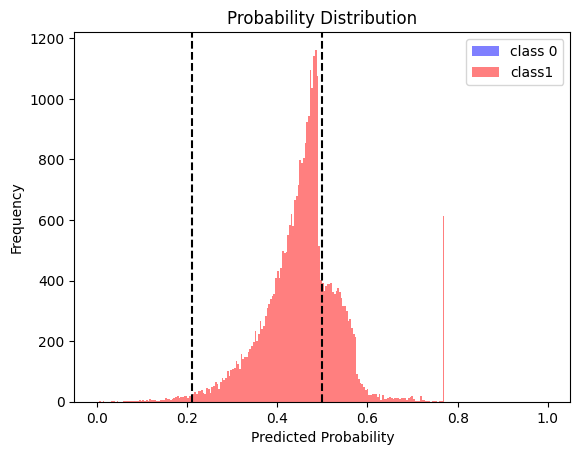

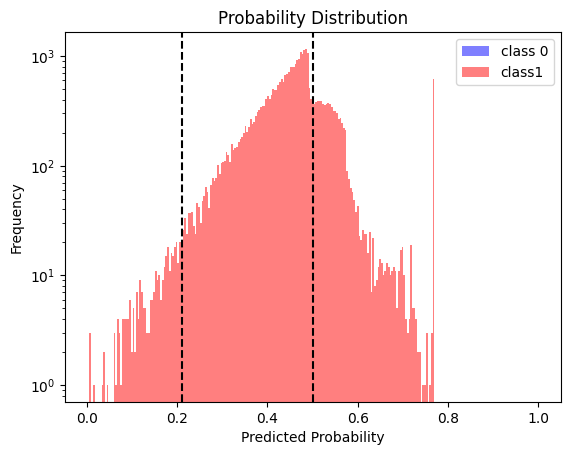

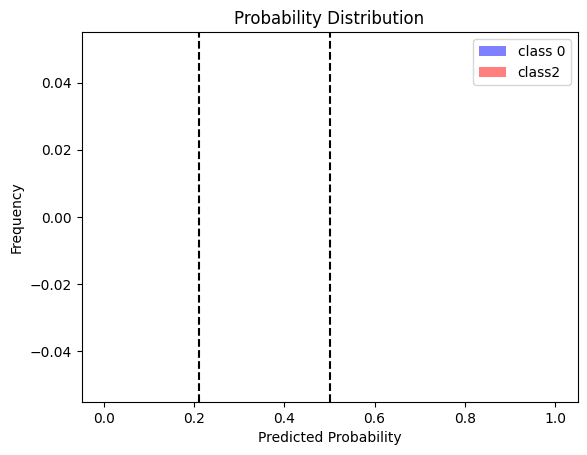

<ipython-input-15-3c6d36adeb3c>:23: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


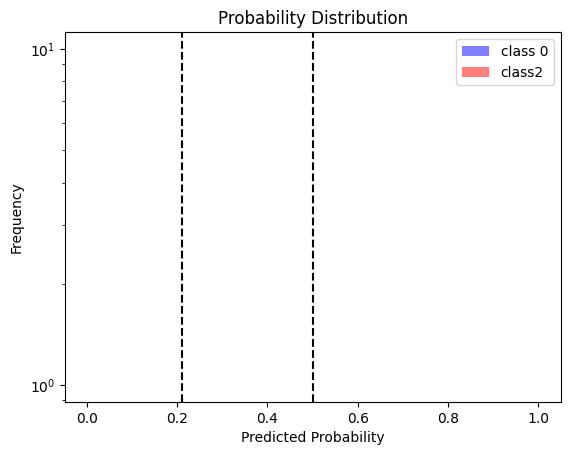

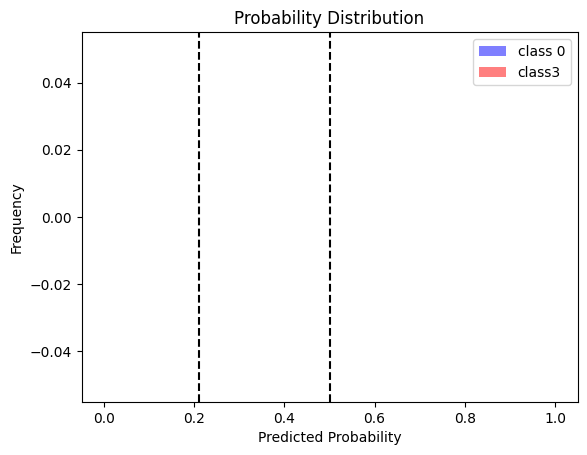

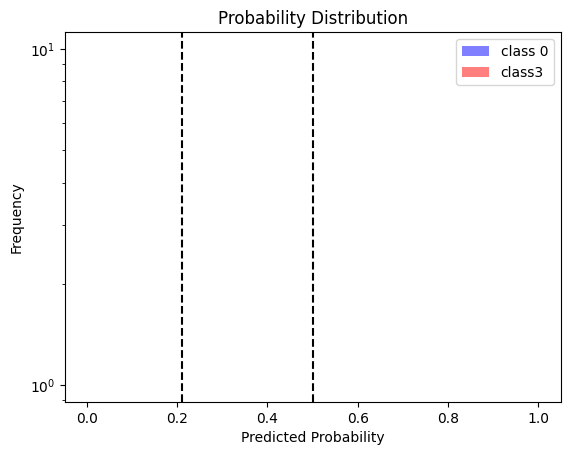

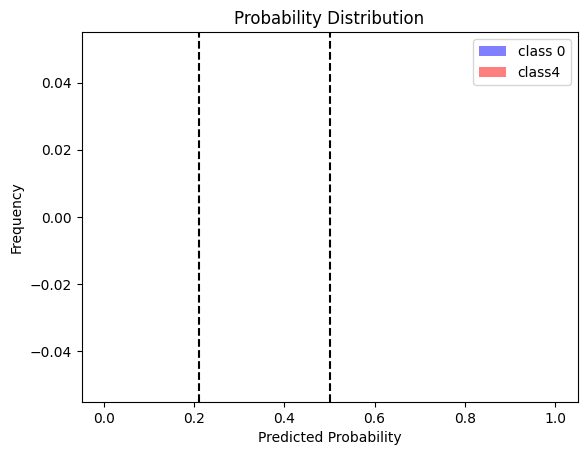

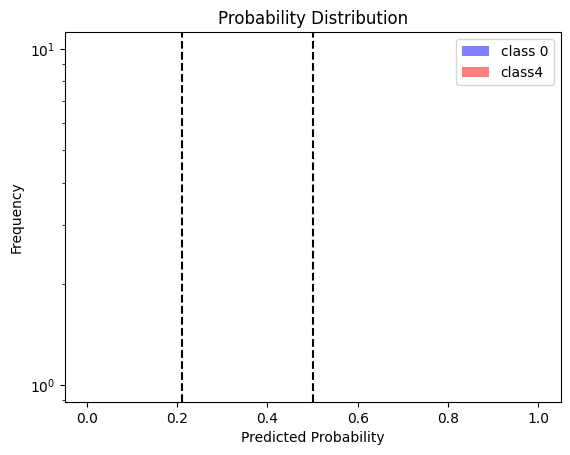

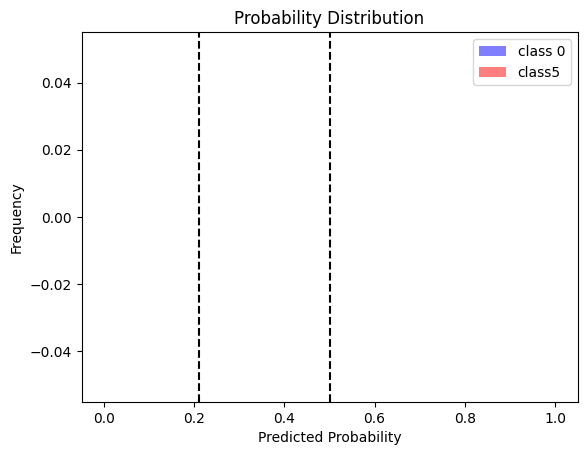

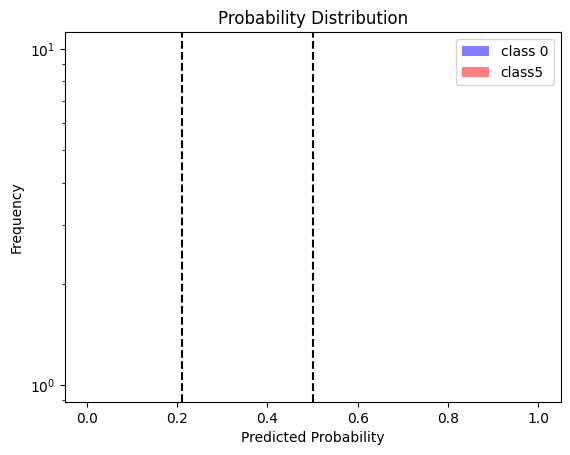

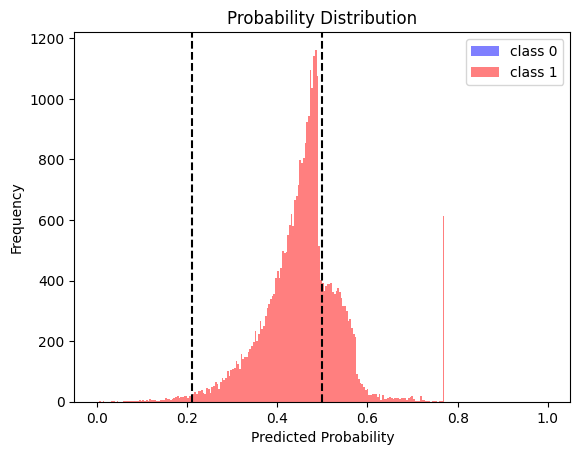

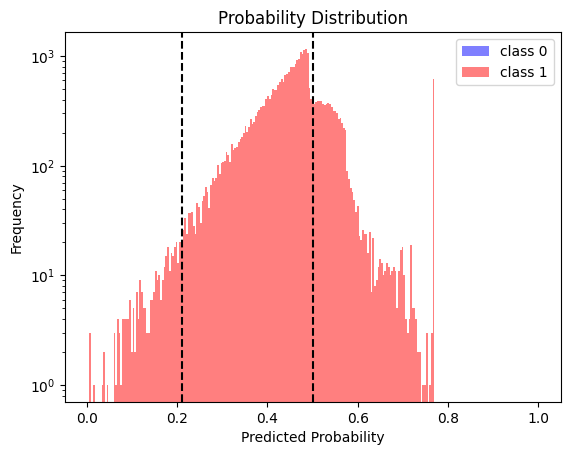

y_pred_0 の要素数: 0
y_pred_1 の要素数: 34026
y_pred_1> 0.21 の割合: 0.9904190912831364
y_pred_1> 0.5 の割合: 0.23367424910362664
y_pred_track[0] の要素数: 0


ZeroDivisionError: division by zero

In [ ]:
threshold = 0.21
threshold1 = 0.5


#出力の確率分布を表示
def plot_ditribution(data_0, data_1, title, class_label_0, class_label_1):
  plt.hist(data_0, bins=200, alpha=0.5, color='blue', label=class_label_0)
  plt.hist(data_1, bins=200, alpha=0.5, color='red', label=class_label_1)
  plt.xlabel('Predicted Probability')
  plt.ylabel('Frequency')
  plt.title(title)
  plt.axvline(x=threshold1, color='black', linestyle='--')
  plt.axvline(x=threshold, color='black', linestyle='--')
  plt.legend()
  plt.show()
  plt.hist(data_0, bins=200, alpha=0.5, color='blue', label=class_label_0)
  plt.hist(data_1, bins=200, alpha=0.5, color='red', label=class_label_1)
  plt.xlabel('Predicted Probability')
  plt.ylabel('Frequency')
  plt.title(title)
  plt.axvline(x=threshold1, color='black', linestyle='--')
  plt.axvline(x=threshold, color='black', linestyle='--')
  plt.yscale('log')
  plt.legend()
  plt.show()

plot_ditribution(y_pred_track[0], y_pred_track[1], 'Probability Distribution', 'class 0', 'class1')
plot_ditribution(y_pred_track[0], y_pred_track[2], 'Probability Distribution', 'class 0', 'class2')
plot_ditribution(y_pred_track[0], y_pred_track[3], 'Probability Distribution', 'class 0', 'class3')
plot_ditribution(y_pred_track[0], y_pred_track[4], 'Probability Distribution', 'class 0', 'class4')
plot_ditribution(y_pred_track[0], y_pred_track[5], 'Probability Distribution', 'class 0', 'class5')

plt.hist(y_pred_0, bins=200, alpha=0.5, color='blue', label='class 0')
plt.hist(y_pred_1, bins=200, alpha=0.5, color='red', label='class 1')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution')
plt.axvline(x=threshold1, color='black', linestyle='--')
plt.axvline(x=threshold, color='black', linestyle='--')
# plt.yscale('log')
plt.legend()
plt.show()
plt.hist(y_pred_0, bins=200, alpha=0.5, color='blue', label='class 0')
plt.hist(y_pred_1, bins=200, alpha=0.5, color='red', label='class 1')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution')
plt.axvline(x=threshold1, color='black', linestyle='--')
plt.axvline(x=threshold, color='black', linestyle='--')
plt.yscale('log')
plt.legend()
plt.show()

print("y_pred_0 の要素数:", len(y_pred_0))
print("y_pred_1 の要素数:", len(y_pred_1))
# print(f'y_pred_0> {threshold} の割合:', len(y_pred_0[y_pred_0 > threshold] == "true") / len(y_pred_0))
print(f"y_pred_1> {threshold} の割合:", len(y_pred_1[y_pred_1 > threshold] == "true") / len(y_pred_1))

# print(f'y_pred_0> {threshold1} の割合:', len(y_pred_0[y_pred_0 > threshold1] == "true") / len(y_pred_0))
print(f"y_pred_1> {threshold1} の割合:", len(y_pred_1[y_pred_1 > threshold1] == "true") / len(y_pred_1))

thresholds = [threshold, threshold1]
for i in range(6):
    print(f"y_pred_track[{i}] の要素数:", len(y_pred_track[i]))
    for t in thresholds:
        print(f'y_pred_track[{i}]> {t} の割合:', len(y_pred_track[i][y_pred_track[i] > t] == "true") / len(y_pred_track[i]))